https://github.com/bnsreenu/python_for_microscopists/blob/master/076-077-078-Unet_nuclei_tutorial.py

In [ ]:
import this

In [22]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

In [1]:
import tensorflow as tf

## Image Input

In [7]:
from numpy import load

In [9]:
X_train = load('X_train.npy')
X_test = load('X_test.npy')
Y_train = load('Y_train.npy')

In [2]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [3]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

## Model Architecture

In [4]:
# Contraction path
# he_normal für Anfangsgewichte, Normalverteilung, die truncated und um 0 centered ist
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path 
# Transpose: upscaling statt wie vorher downscaling
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# Output Layer
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
_______________________________________________________________________________________

## Model fit

In [5]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True),
             tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [10]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
 1/38 [..............................] - ETA: 0s - loss: 0.7081 - accuracy: 0.5179WARNING:tensorflow:From C:\Users\Lain\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
38/38 [==============================] - ETA: 0s - loss: 0.4984 - accuracy: 0.7937
Epoch 00001: val_loss improved from inf to 0.28110, saving model to model_for_nuclei.h5
38/38 [==============================] - 77s 2s/step - loss: 0.4984 - accuracy: 0.7937 - val_loss: 0.2811 - val_accuracy: 0.8497
Epoch 2/25
38/38 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.8637
Epoch 00002: val_loss improved from 0.28110 to 0.18550, saving model to model_for_nuclei.h5
38/38 [==============================] - 76s 2s/step - loss: 0.2653 - accuracy: 0.8637 - val_loss: 0.1855 - val_accuracy: 0.9243
Epoch 3/25


## Model predict

In [15]:
idx = np.random.randint(0, len(X_train))

In [16]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

3/3 [==============================] - 1s 238ms/step


In [17]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

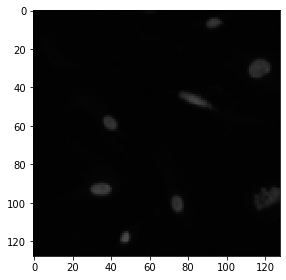

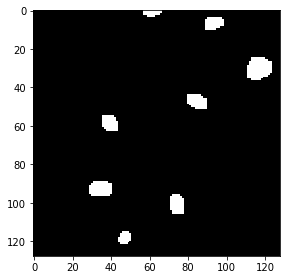

C:\Users\Lain\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


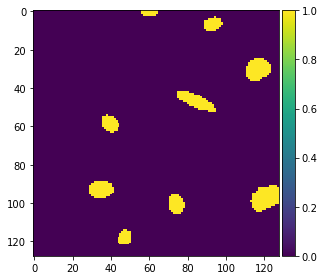

In [23]:
ix = np.random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

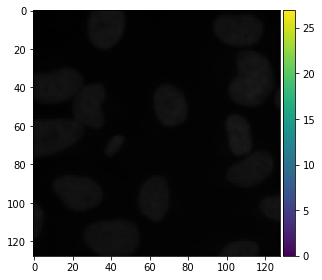

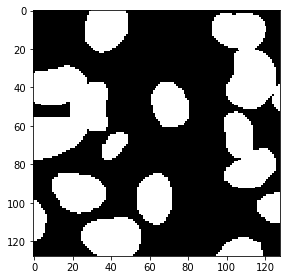

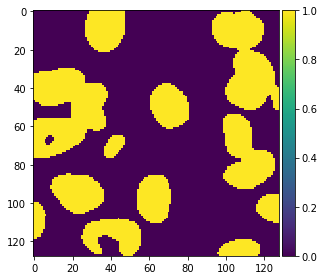

In [25]:
# Perform a sanity check on some random validation samples
ix = np.random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [26]:
! tensorboard --logdir=logs/ --host localhost --port 8088

^C


im Browser
http://localhost:8088/#scalars